# Reconstruction

In [2]:
import  numpy as np
import tensorflow as tf
from PIL import Image
import matplotlib.pyplot as plt

In [48]:
tf.reset_default_graph()
with tf.Session() as sess:
    original_tensor = tf.random_uniform([2,4,4,3],maxval=100,dtype='float32',seed=2)
    print('The Origianl tensor:\n',sess.run(original_tensor))

The Origianl tensor:
 [[[[67.87466   71.41509   46.981693 ]
   [48.19697   47.838177  55.389534 ]
   [23.514807  43.864334  48.487686 ]
   [83.74739   66.826546  81.30921  ]]

  [[21.17182   14.59359   47.21594  ]
   [25.947487  76.70528    9.677148 ]
   [74.96898   15.725458  36.215782 ]
   [40.158104  46.98137   37.93695  ]]

  [[19.174026  13.3460045 63.323986 ]
   [75.63816   39.963745  50.45898  ]
   [ 4.3593407 71.83367   95.57234  ]
   [ 0.6375313 26.810669  83.417336 ]]

  [[27.075409  90.009605   6.515014 ]
   [66.92245   60.669815  63.901222 ]
   [ 9.095299  87.97344   11.553419 ]
   [67.55619   50.58228   57.455753 ]]]


 [[[25.731766  41.152336  16.108143 ]
   [70.12293   63.709034  67.799484 ]
   [98.37727   56.834244  34.41763  ]
   [22.97107   95.74716   73.509445 ]]

  [[70.47747   44.06829   16.02174  ]
   [44.56004   49.472202  64.17332  ]
   [90.14995   19.46274   62.690926 ]
   [76.13794   12.588406  85.800186 ]]

  [[63.070095  35.507168   1.6166806]
   [29.15386  

In [49]:
with tf.Session() as sess:
    argmax_value_index = tf.nn.max_pool_with_argmax(original_tensor, ksize=[1,2,2,1],
                                                    strides=[1,2,2,1], padding='SAME')
    value,index = sess.run(argmax_value_index)
    print('The pool result is:\n',value)
    print('The pool argmax index is:\n',index)

The pool result is:
 [[[[67.87466  76.70528  55.389534]
   [83.74739  66.826546 81.30921 ]]

  [[75.63816  90.009605 63.901222]
   [67.55619  87.97344  95.57234 ]]]


 [[[70.47747  63.709034 67.799484]
   [98.37727  95.74716  85.800186]]

  [[63.070095 75.97483  62.26231 ]
   [51.711823 76.2678   81.52241 ]]]]
The pool argmax index is:
 [[[[ 0 16  5]
   [ 9 10 11]]

  [[27 37 41]
   [45 43 32]]]


 [[[60 52 53]
   [54 58 71]]

  [[72 88 77]
   [81 82 95]]]]


In [50]:
def UnPool(value,index,output_shape):
    print(index.shape)
    p_b,p_h,p_w,p_c = value.shape
    h,w,c = output_shape
    zeros = np.zeros((p_b*h*w*c))
    value_ = value.reshape((p_b,p_h*p_w*p_c))
    index_ = index.reshape((p_b,p_h*p_w*p_c))
    for i in range(p_b):
        zeros[index_[i]] += value_[i]
    zeros = zeros.reshape((p_b,h,w,c))
#     zeros = tf.convert_to_tensor(zeros,dtype=tf.float32)
    return zeros

In [52]:
value.shape

(2, 2, 2, 3)

In [82]:
with tf.Session() as sess:
    print(sess.run(original_tensor)[0,0:2,0:2,0])

[[67.87466  48.19697 ]
 [21.17182  25.947487]]


In [70]:
value[0,0,0,0]

67.87466

In [71]:
index[0,0,0,0]

0

In [72]:
unpool[0,0:2,0:2,0]

array([[67.87465668,  0.        ],
       [ 0.        ,  0.        ]])

In [73]:
value[0,0,0,1]

76.70528

In [74]:
unpool[0,0:2,0:2,1]

array([[ 0.        ,  0.        ],
       [ 0.        , 76.70527649]])

In [76]:
value[1,0,0,2]

67.799484

In [77]:
unpool[1,0:2,0:2,2]

array([[ 0.        , 67.79948425],
       [ 0.        ,  0.        ]])

In [51]:
with tf.Session() as sess:
    output_shape = [4,4,3]
    unpool = UnPool(value,index,output_shape)
#     print('The unpool result is:\n',sess.run(unpool))

(2, 2, 2, 3)


### Test one Picture at Transposed CONV

### 1. Read Image

### 2. LoadModel

In [19]:
class Reconstruction:
    def __init__(self,model_dir,img_path):
        tf.reset_default_graph()
        
        self.sess = tf.Session()
        self.model_dir = model_dir
        self.img_path = img_path
        self.resize_shape = (227, 227)
        self.layers_param = {'input_shape':(1,227,227,3),
                            'conv1_strides':(1,4,4,1),
                            'conv1_outshape':(1,55,55,96),
                            'pool1_ksize':(1,3,3,1),
                            'pool1_strides':(1,2,2,1),
                            'pool1_outshape':(1,27,27,96),
                            'conv2_strides':(1,1,1,1),
                            'conv2_outshape':(1,27,27,256),
                            'pool2_ksize':(1,3,3,1),
                            'pool2_strides':(1,2,2,1),
                            'pool2_outshape':(1,13,13,256),
                            'conv3_strides':(1,1,1,1),
                            'conv3_outshape':(1,13,13,384),
                            'conv4_strides':(1,1,1,1),
                            'conv4_outshape':(1,13,13,384),
                            'conv5_strides':(1,1,1,1),
                            'conv5_outshape':(1,13,13,256),
                            'pool5_ksize':(1,3,3,1),
                            'pool5_strides':(1,2,2,1),
                            'pool5_outshape':(1,6,6,256)
                             
                            }
        
        
    def Openimage(self):
        new_width = 227
        new_height = 227
        img = Image.open(self.img_path)
        img = img.resize((new_width,new_height))
#         width, height = img.size   # Get dimensions
#         left = np.floor((width - new_width)/2)
#         top = np.floor((height - new_height)/2)
#         right = np.floor((width + new_width)/2)
#         bottom = np.floor((height + new_height)/2)

#         img = img.crop((left, top, right, bottom))
#         print(img.size)
        img = np.array(img)
#         img = np.pad(img,pad_width=((32,32),(32,32),(0,0)),mode='constant')
        
        img = img.reshape(self.layers_param['input_shape'])
        self.img = tf.convert_to_tensor(img,tf.float32)
        print(self.img)
        # crop 163x163 padding 227
    
    def LoadModel(self):
        self.param = {}
        new_saver = tf.train.import_meta_graph(self.model_dir + '.meta')
        new_saver.restore(self.sess, self.model_dir)
        graph = tf.get_default_graph()
        
        for i in range(5):
            W = graph.get_tensor_by_name('W%d:0'%(i+1))
            b = graph.get_tensor_by_name('b%d:0'%(i+1))
            self.param['W%d'%(i+1)] = W
            self.param['b%d'%(i+1)] = b
            
        
    def _conv2d(self,input_,kernel,strides=[1,1,1,1],padding="VALID",name=None):
        conv2d_ = tf.nn.conv2d(input_,kernel,strides,padding,name=name)
        return conv2d_
    
    def _argmaxpool(self,value,ksize,strides=[1,1,1,1],padding="VALID",name=None):
        argmaxpool_ = tf.nn.max_pool_with_argmax(value,ksize,strides,padding,name)
        return argmaxpool_
    
    def _lrn(self,input_,depth_radius=5,bias=2,alpha=1e-4,beta=0.75,name=None):
        lrn_ = tf.nn.lrn(input_,depth_radius,bias,alpha,beta,name)
        return lrn_
    
    def conv1(self):
        W1 = self.param['W1']
        b1 = self.param['b1']
        conv2d_ = self._conv2d(input_= self.img,kernel=W1,strides=self.layers_param['conv1_strides']) + b1
        relu_ = tf.nn.relu(conv2d_)
        argmaxpool_ = self._argmaxpool(value=relu_,ksize=self.layers_param['pool1_ksize'],
                                       strides=self.layers_param['pool1_strides'])
        lrn_ = self._lrn(argmaxpool_[0])
        return lrn_,argmaxpool_
    
    def conv2(self):
        W2 = self.param['W2']
        b2 = self.param['b2']
        lrn_1,_ = self.conv1()
        conv2d_ = self._conv2d(input_=lrn_1,kernel=W2,strides=self.layers_param['conv2_strides'],padding="SAME") + b2
        relu_ = tf.nn.relu(conv2d_)
        argmaxpool_ = self._argmaxpool(value=relu_,ksize=self.layers_param['pool2_ksize'],
                                       strides=self.layers_param['pool2_strides'])
        lrn_ = self._lrn(argmaxpool_[0])
        return lrn_,argmaxpool_
    
    def conv3(self):
        W3 = self.param['W3']
        b3 = self.param['b3']
        lrn_2,_ = self.conv2()
        conv2d_ = self._conv2d(input_=lrn_2,kernel=W3,strides=self.layers_param['conv3_strides'],padding="SAME") + b3
        relu_ = tf.nn.relu(conv2d_)
        return relu_
    
    def conv4(self):
        W4 = self.param['W4']
        b4 = self.param['b4']
        relu_3 = self.conv3()
        conv2d_ = self._conv2d(input_=relu_3,kernel=W4,strides=self.layers_param['conv4_strides'],padding="SAME") + b4
        relu_ = tf.nn.relu(conv2d_)
        return relu_
    
    def conv5(self):
        W5 = self.param['W5']
        b5 = self.param['b5']
        relu_4 = self.conv4()
        conv2d_ = self._conv2d(input_=relu_4,kernel=W5,strides=self.layers_param['conv5_strides'],padding="SAME") + b5
        relu_ = tf.nn.relu(conv2d_)
        argmaxpool_ = self._argmaxpool(value=relu_,ksize=self.layers_param['pool5_ksize'],
                                       strides=self.layers_param['pool5_strides'])
        return relu_,argmaxpool_
    
    def Unpool(self,value,index,output_shape):
        p_b,p_h,p_w,p_c = value.shape
        h,w,c = output_shape
        zeros = np.zeros((p_b,h*w*c))
        value_ = value.reshape((p_b,p_h*p_w*p_c))
        index_ = index.reshape((p_b,p_h*p_w*p_c))
        zeros[:,index_] = value_
        zeros = zeros.reshape((p_b,h,w,c))
        
        unpool_ = tf.convert_to_tensor(zeros,dtype=tf.float32)
        
        del zeros
        
        return unpool_
    
    def Deconv2d(self,value,filter_,output_shape,strides,padding="SAME",name=None):
        deconv2d_ = tf.nn.conv2d_transpose(value,filter_,output_shape = output_shape,
                                           strides=strides,padding=padding,
                                           name=name)
        return deconv2d_
    
    def Randomsetzeros(self,W):
        W_ = self.sess.run(W)
        
        W_out = np.zeros(W.shape)
#         random_num = 10
#         W_out[:,:,:,random_num] = W_[:,:,:,random_num]
        W_out = W_
        
        W_out = tf.convert_to_tensor(W_out,tf.float32)
        return W_out
    
    def Normal(self,deconv):
        deconv_out = self.sess.run(deconv)
        deconv_out = ((deconv_out - deconv_out.min())*255) / (deconv_out.max() - deconv_out.min())
        return deconv_out.astype('uint8')
    
    def Deconv(self,outshape,weights,inshape,strides,padding,value,index=None,is_unpool=True):
        if is_unpool:
            unpool_ = self.Unpool(value,index,self.layers_param[outshape][1:])
            relu_ = tf.nn.relu(unpool_)
        else:
            relu_ = value
        W_out_ = self.Randomsetzeros(self.param[weights])
        output_shape = self.layers_param[inshape]
        strides = self.layers_param[strides]

        deconv2d_ = self.Deconv2d(relu_,W_out_,output_shape,strides,padding)

        return deconv2d_
        
        
    def deconv1(self):
        _,argmaxpool_1 = self.conv1()
        value,index = self.sess.run(argmaxpool_1)
        
        deconv2d_1 = self.Deconv('conv1_outshape','W1','input_shape','conv1_strides','VALID',value,index)
        out = self.Normal(deconv2d_1)
        return out
    
    def deconv2(self):
        _,argmaxpool_2 = self.conv2()
        value,index = self.sess.run(argmaxpool_2)
        deconv2d_2 = self.Deconv('conv2_outshape','W2','pool1_outshape','conv2_strides','SAME',value,index)
        
        _,argmaxpool_1 = self.conv1()
        _,index = self.sess.run(argmaxpool_1)
        value = self.sess.run(deconv2d_2)
        
        deconv2d_1 = self.Deconv('conv1_outshape','W1','input_shape','conv1_strides','VALID',value,index)
        out = self.Normal(deconv2d_1)
        return out
    
    def deconv3(self):
        relu_3 = self.conv3()
        relu_3 = self.sess.run(relu_3)
        deconv2d_3 = self.Deconv('conv3_outshape','W3','pool2_outshape','conv3_strides','SAME',relu_3,is_unpool=False)
        
        _,argmaxpool_2 = self.conv2()
        _,index = self.sess.run(argmaxpool_2)
        value = self.sess.run(deconv2d_3)
        deconv2d_2 = self.Deconv('conv2_outshape','W2','pool1_outshape','conv2_strides','SAME',value,index)
        
        _,argmaxpool_1 = self.conv1()
        _,index = self.sess.run(argmaxpool_1)
        value = self.sess.run(deconv2d_2)
        
        deconv2d_1 = self.Deconv('conv1_outshape','W1','input_shape','conv1_strides','VALID',value,index)
        out = self.Normal(deconv2d_1)
        return out
    
    def deconv4(self):
        relu_4 = self.conv4()
        relu_ = self.sess.run(relu_4)
        deconv2d_4 = self.Deconv('conv4_outshape','W4','conv3_outshape','conv4_strides','SAME',relu_,is_unpool=False)
        
        deconv2d_3 = self.Deconv('conv3_outshape','W3','pool2_outshape','conv3_strides','SAME',deconv2d_4,is_unpool=False)
        _,argmaxpool_2 = self.conv2()
        _,index = self.sess.run(argmaxpool_2)
        value = self.sess.run(deconv2d_3)
        deconv2d_2 = self.Deconv('conv2_outshape','W2','pool1_outshape','conv2_strides','SAME',value,index)
        
        _,argmaxpool_1 = self.conv1()
        _,index = self.sess.run(argmaxpool_1)
        value = self.sess.run(deconv2d_2)
        
        deconv2d_1 = self.Deconv('conv1_outshape','W1','input_shape','conv1_strides','VALID',value,index)
        out = self.Normal(deconv2d_1)
        return out
    
    def deconv5(self):
        _,argmaxpool_5 = self.conv5()
        value,index = self.sess.run(argmaxpool_5)
        
        deconv2d_5 = self.Deconv('conv5_outshape','W5','conv4_outshape','conv5_strides','SAME',value,index)
        
        deconv2d_4 = self.Deconv('conv4_outshape','W4','conv3_outshape','conv4_strides','SAME',deconv2d_5,is_unpool=False)
        
        deconv2d_3 = self.Deconv('conv3_outshape','W3','pool2_outshape','conv3_strides','SAME',deconv2d_4,is_unpool=False)
        
        _,argmaxpool_2 = self.conv2()
        _,index = self.sess.run(argmaxpool_2)
        value = self.sess.run(deconv2d_3)
        deconv2d_2 = self.Deconv('conv2_outshape','W2','pool1_outshape','conv2_strides','SAME',value,index)
        
        _,argmaxpool_1 = self.conv1()
        _,index = self.sess.run(argmaxpool_1)
        value = self.sess.run(deconv2d_2)
        
        deconv2d_1 = self.Deconv('conv1_outshape','W1','input_shape','conv1_strides','VALID',value,index)
        out = self.Normal(deconv2d_1)
        return out
    
    def Visualization(self,layer="conv1"):
        if layer == 'conv1':
            out = self.deconv1()
            
        elif layer == 'conv2':
            out = self.deconv2()
            
        elif layer == 'conv3':
            out = self.deconv3()
        elif layer == 'conv4':
            out = self.deconv4()
        elif layer == 'conv5':
            out = self.deconv5()
            
        return out

In [20]:
model_dir = 'Model_AlexNet/alexnet'
img_path = 'cat.4.jpg'
reconstruction = Reconstruction(model_dir,img_path)

reconstruction.Openimage()

reconstruction.LoadModel()

Tensor("Const:0", shape=(1, 227, 227, 3), dtype=float32)
INFO:tensorflow:Restoring parameters from Model_AlexNet/alexnet


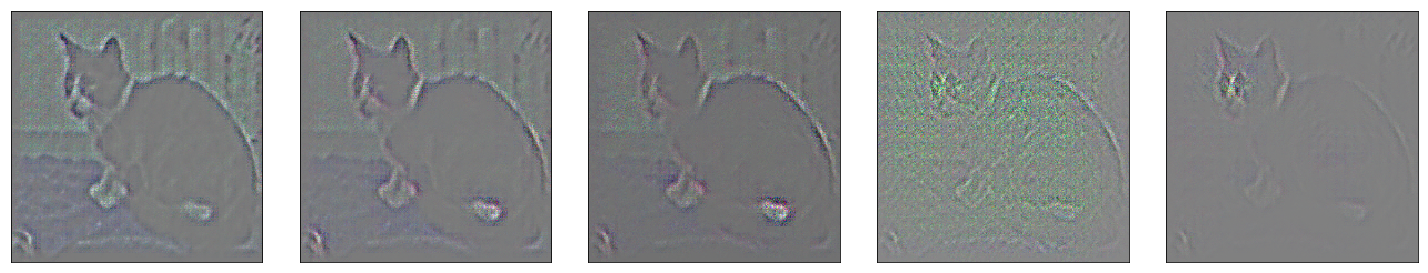

In [21]:
fig = plt.figure(figsize=(20,20))
for i in range(1,6):
    ax = plt.subplot(1,5,i)
    plt.tight_layout()
    out = reconstruction.Visualization(layer='conv%d'%i)
    plt.imshow(out[0])
    plt.xticks(())
    plt.yticks(())

Tensor("Const:0", shape=(1, 227, 227, 3), dtype=float32)
INFO:tensorflow:Restoring parameters from Model_AlexNet/alexnet


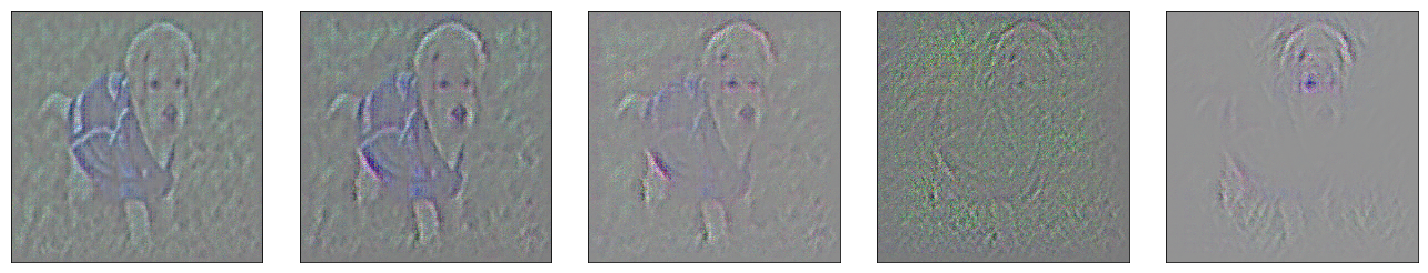

In [22]:
model_dir = 'Model_AlexNet/alexnet'
img_path = 'dog.jpg'
reconstruction = Reconstruction(model_dir,img_path)

reconstruction.Openimage()

reconstruction.LoadModel()

fig = plt.figure(figsize=(20,20))
for i in range(1,6):
    ax = plt.subplot(1,5,i)
    plt.tight_layout()
    out = reconstruction.Visualization(layer='conv%d'%i)
    plt.imshow(out[0])
    plt.xticks(())
    plt.yticks(())

Tensor("Const:0", shape=(1, 227, 227, 3), dtype=float32)
INFO:tensorflow:Restoring parameters from Model_AlexNet/alexnet


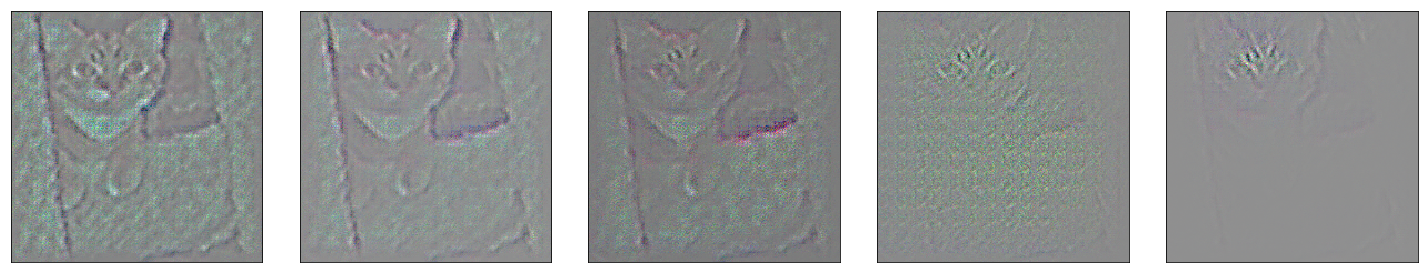

In [23]:
model_dir = 'Model_AlexNet/alexnet'
img_path = '15.jpg'
reconstruction = Reconstruction(model_dir,img_path)

reconstruction.Openimage()

reconstruction.LoadModel()

fig = plt.figure(figsize=(20,20))
for i in range(1,6):
    ax = plt.subplot(1,5,i)
    plt.tight_layout()
    out = reconstruction.Visualization(layer='conv%d'%i)
    plt.imshow(out[0])
    plt.xticks(())
    plt.yticks(())

In [1]:
2500*2048

5120000